# Import Libraries

In [1]:
import os
import glob
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model

2026-01-27 21:49:43.585505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769550583.812372      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769550583.880662      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769550584.433610      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769550584.433653      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769550584.433655      55 computation_placer.cc:177] computation placer alr

# understand the data

In [2]:
def count_images(path):
    for folder in os.listdir(path):
        Images= glob.glob(os.path.join(path, folder, '*.jpg'))
        print(f'Folder: {folder}, Number of images: {len(Images)}')

In [3]:
def plot_image_counts(path):
    Image_count = {}
    for folder in os.listdir(path):
        Images= len(glob.glob(os.path.join(path, folder, '*.jpg')))
        Image_count[folder] = Images

    plt.Figure(figsize=(10,5))
    plt.bar(Image_count.keys(), Image_count.values())
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title(f'Number of images per class in {os.path.basename(path)} dataset')
    plt.show()


In [4]:
def plot_history(histories, phase_names):
    plt.figure(figsize=(14, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for h, name in zip(histories, phase_names):
        plt.plot(h.history['accuracy'], label=f'{name} train')
        plt.plot(h.history['val_accuracy'], label=f'{name} val')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    for h, name in zip(histories, phase_names):
        plt.plot(h.history['loss'], label=f'{name} train')
        plt.plot(h.history['val_loss'], label=f'{name} val')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [12]:
# culculate the size of images
def calculate_image_sizes(path):
    image_sizes = []
    for folder in os.listdir(path):
        Images= glob.glob(os.path.join(path, folder, '*.jpg'))
        for img_path in Images:
            img = cv.imread(img_path)
            if img.shape[:2] not in image_sizes:
                image_sizes.append(img.shape[:2])  
    return image_sizes

## count training images

In [8]:
# count training images
count_images('/kaggle/input/brain-tumor-mri-dataset/Training')

Folder: pituitary, Number of images: 1457
Folder: notumor, Number of images: 1595
Folder: meningioma, Number of images: 1339
Folder: glioma, Number of images: 1321


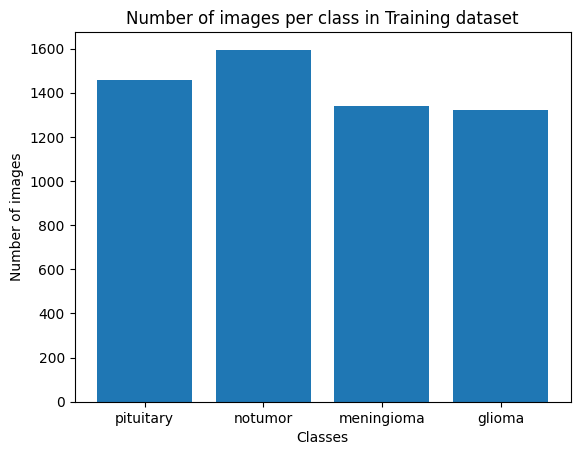

In [9]:
plot_image_counts('/kaggle/input/brain-tumor-mri-dataset/Training')

In [10]:
count_images('/kaggle/input/brain-tumor-mri-dataset/Testing')

Folder: pituitary, Number of images: 300
Folder: notumor, Number of images: 405
Folder: meningioma, Number of images: 306
Folder: glioma, Number of images: 300


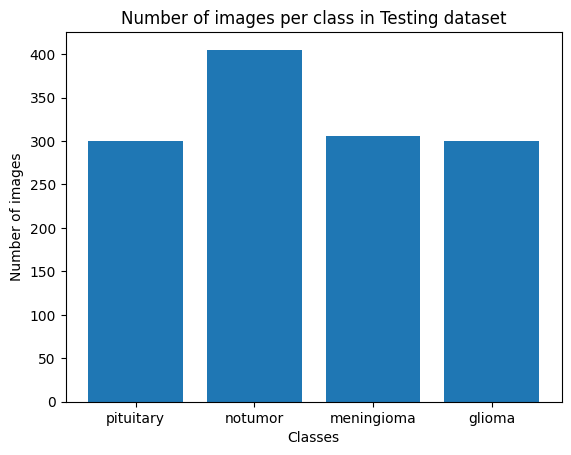

In [11]:
plot_image_counts('/kaggle/input/brain-tumor-mri-dataset/Testing')

## culculate the size of images

In [13]:
calculate_image_sizes('/kaggle/input/brain-tumor-mri-dataset/Training')

[(512, 512),
 (256, 256),
 (1365, 1365),
 (741, 900),
 (378, 360),
 (400, 400),
 (442, 442),
 (681, 685),
 (903, 721),
 (1280, 1280),
 (474, 474),
 (900, 940),
 (502, 502),
 (202, 202),
 (432, 470),
 (210, 201),
 (225, 225),
 (630, 630),
 (236, 214),
 (192, 192),
 (848, 785),
 (248, 208),
 (417, 428),
 (251, 201),
 (234, 209),
 (217, 232),
 (214, 205),
 (664, 550),
 (680, 680),
 (201, 173),
 (223, 236),
 (540, 504),
 (244, 206),
 (248, 217),
 (262, 227),
 (259, 194),
 (214, 235),
 (781, 733),
 (275, 220),
 (725, 728),
 (442, 441),
 (252, 200),
 (442, 400),
 (213, 236),
 (236, 236),
 (197, 177),
 (872, 850),
 (257, 196),
 (282, 230),
 (452, 355),
 (286, 224),
 (221, 228),
 (257, 236),
 (198, 150),
 (350, 350),
 (280, 420),
 (328, 267),
 (222, 227),
 (168, 300),
 (600, 494),
 (400, 393),
 (504, 450),
 (224, 234),
 (449, 359),
 (649, 926),
 (231, 218),
 (242, 208),
 (393, 350),
 (183, 275),
 (474, 356),
 (262, 236),
 (235, 230),
 (340, 339),
 (259, 225),
 (418, 364),
 (225, 208),
 (280, 2

In [14]:
len(calculate_image_sizes('/kaggle/input/brain-tumor-mri-dataset/Testing'))

194

# Data Augmantation

In [15]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training + Validation (with augmentation)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=12,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.20
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Training',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/brain-tumor-mri-dataset/Testing',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


###  load samples from all data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..116.64054].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.79456..150.59091].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..114.18818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..142.75662].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..125.90058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..139.20181].
Clipp

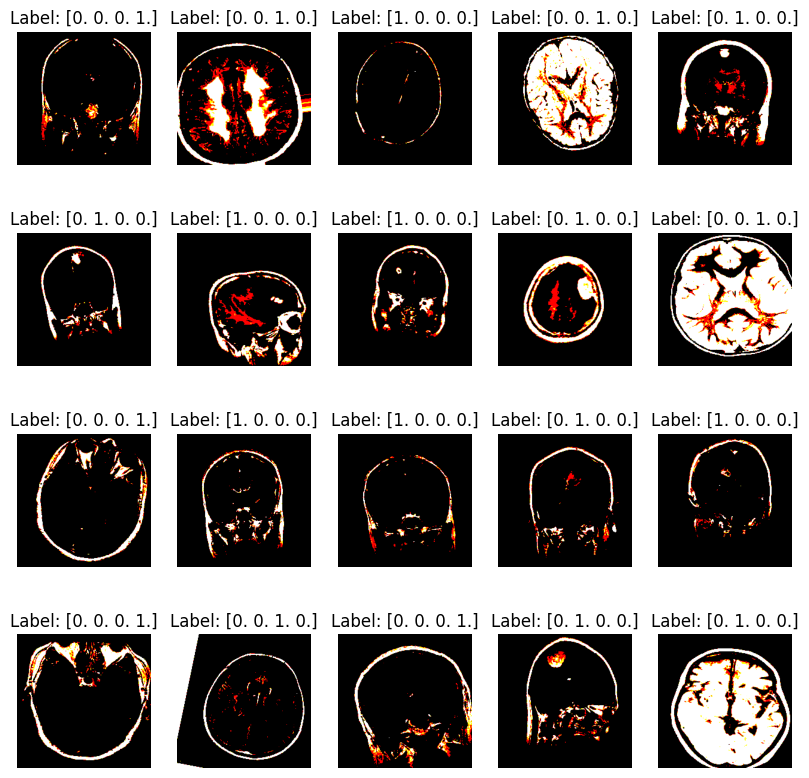

In [ ]:
images, labels = next(train_generator)

plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.axis('off')


### change weights of unbalanced classes

In [17]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


# model Arc

In [18]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze at first

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.45),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.35),
    layers.Dense(4, activation='softmax', name='output')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1769550650.750515      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769550650.754406      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,772,228 (94.50 MB)

 Trainable params: 1,182,980 (4.51 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

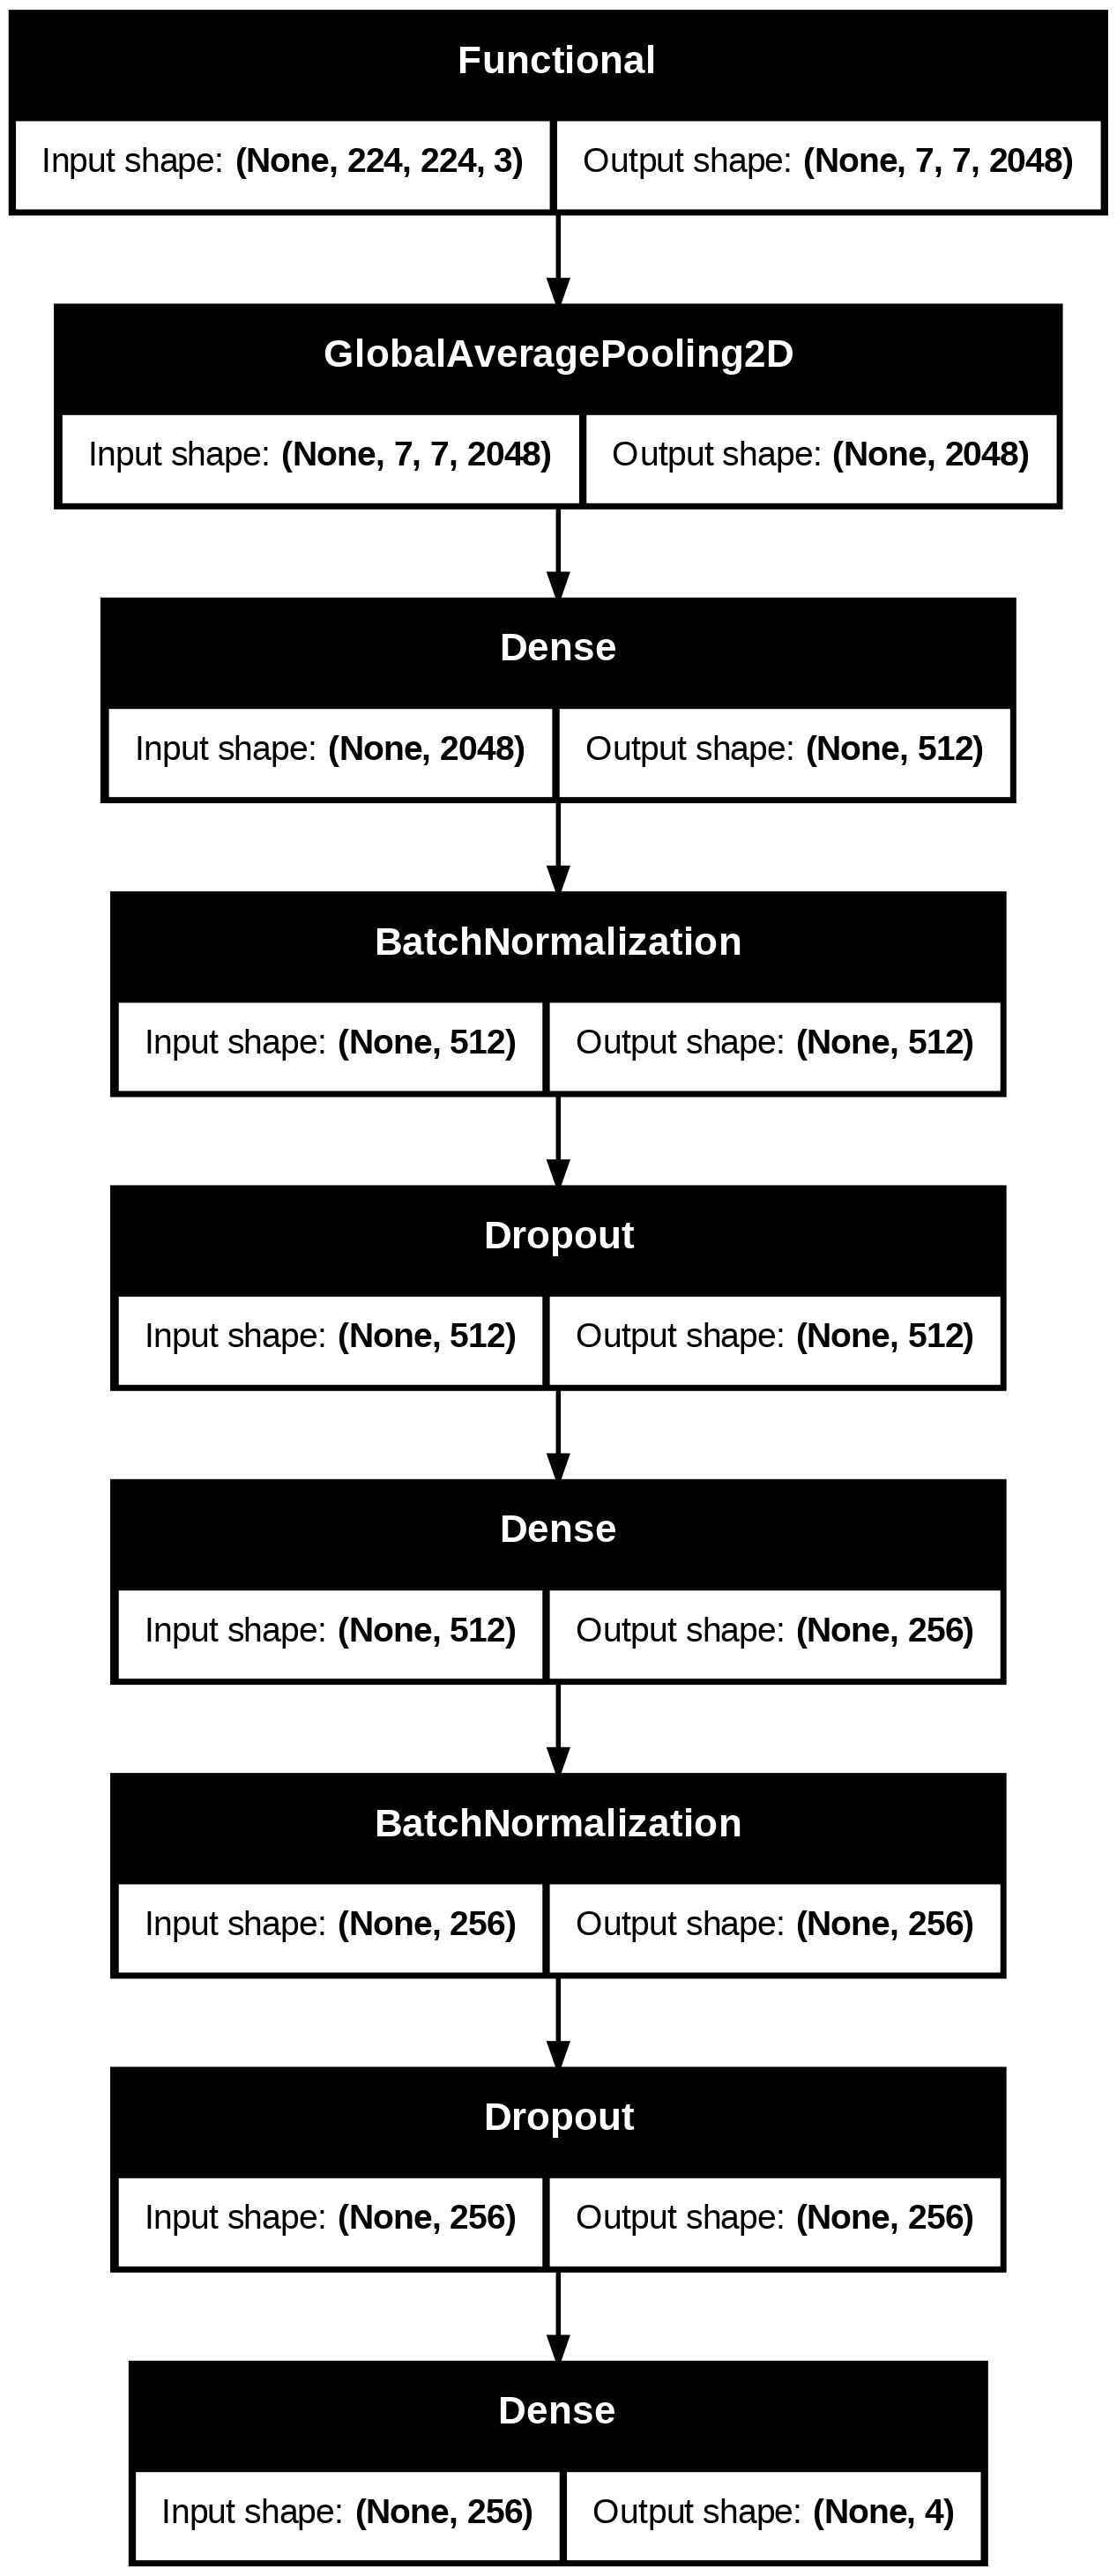

In [19]:
plot_model(model, show_shapes=True)

### early stopping and learning rate reduction

In [20]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('best_model_phase1.keras', monitor='val_accuracy', 
                    save_best_only=True, mode='max', verbose=1)
]

# Phase 1: Training classifier head for warm up the model 

In [ ]:
history_phase1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


=== Phase 1: Training classifier head ===



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1769550663.716047     147 service.cc:152] XLA service 0x7c67cc013bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769550663.716092     147 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769550663.716115     147 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769550665.718372     147 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/143 ━━━━━━━━━━━━━━━━━━━━ 36:45 16s/step - accuracy: 0.2812 - loss: 1.7807

I0000 00:00:1769550671.833521     147 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7585 - loss: 0.7109
Epoch 1: val_accuracy improved from -inf to 0.83961, saving model to best_model_phase1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 568ms/step - accuracy: 0.7590 - loss: 0.7097 - val_accuracy: 0.8396 - val_loss: 0.4729 - learning_rate: 0.0010
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8751 - loss: 0.3379
Epoch 2: val_accuracy improved from 0.83961 to 0.84926, saving model to best_model_phase1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 462ms/step - accuracy: 0.8752 - loss: 0.3378 - val_accuracy: 0.8493 - val_loss: 0.4124 - learning_rate: 0.0010
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8973 - loss: 0.2788
Epoch 3: val_accuracy improved from 0.84926 to 0.85890, saving model to best_model_phase1.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 460ms/step - accuracy: 0.8972 - loss: 0.2789 - val_accuracy: 0.8589 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 4/10
143/143 ━━━━━━━━━━━

# Phase 2: Fine-tuning last layers

In [ ]:

set_trainable = False
for layer in base_model.layers:
    if "conv5" in layer.name:
        set_trainable = True
    layer.trainable = set_trainable


# Recompile with much smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training from best weights
history_phase2 = model.fit(
    train_generator,
    epochs=15,                # can be more
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7),
        ModelCheckpoint('best_model_final.keras', monitor='val_accuracy', 
                        save_best_only=True, mode='max')
    ]
)


=== Phase 2: Fine-tuning last layers ===

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 101s 562ms/step - accuracy: 0.9261 - loss: 0.2056 - val_accuracy: 0.9115 - val_loss: 0.2595 - learning_rate: 3.0000e-05
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 473ms/step - accuracy: 0.9528 - loss: 0.1337 - val_accuracy: 0.9264 - val_loss: 0.2294 - learning_rate: 3.0000e-05
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 68s 473ms/step - accuracy: 0.9681 - loss: 0.0893 - val_accuracy: 0.9334 - val_loss: 0.2142 - learning_rate: 3.0000e-05
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 67s 470ms/step - accuracy: 0.9782 - loss: 0.0697 - val_accuracy: 0.9264 - val_loss: 0.2410 - learning_rate: 3.0000e-05
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 464ms/step - accuracy: 0.9813 - loss: 0.0638 - val_accuracy: 0.9439 - val_loss: 0.1929 - learning_rate: 3.0000e-05
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 65s 452ms/step - accuracy: 0.9879 - loss: 0.0401 - val_accuracy: 0.9343 - val_loss: 0.2311 - learning_rate: 3.0000e-05
Ep

# Evaluation

In [23]:
print("\n=== Final Evaluation on Test Set ===\n")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}  |  Test loss: {test_loss:.4f}")


=== Final Evaluation on Test Set ===

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.9602 - loss: 0.1284
Test accuracy: 0.9703  |  Test loss: 0.1078


41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step


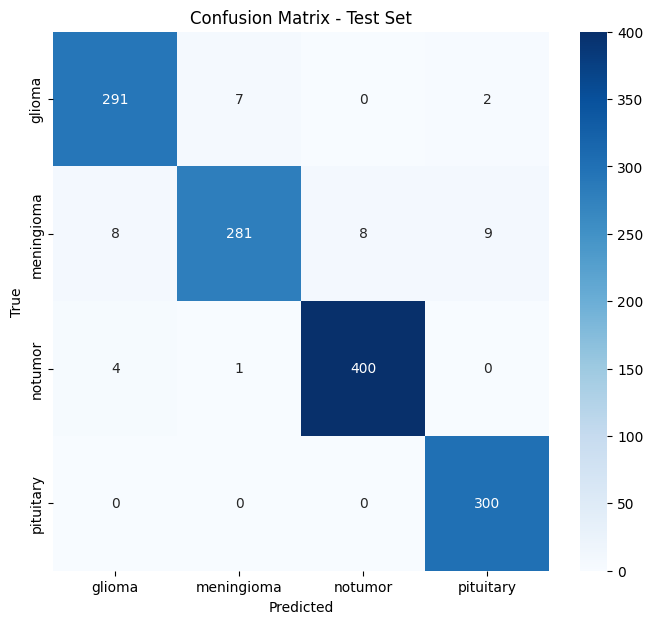


Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.97      0.97       300
  meningioma       0.97      0.92      0.94       306
     notumor       0.98      0.99      0.98       405
   pituitary       0.96      1.00      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [24]:
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

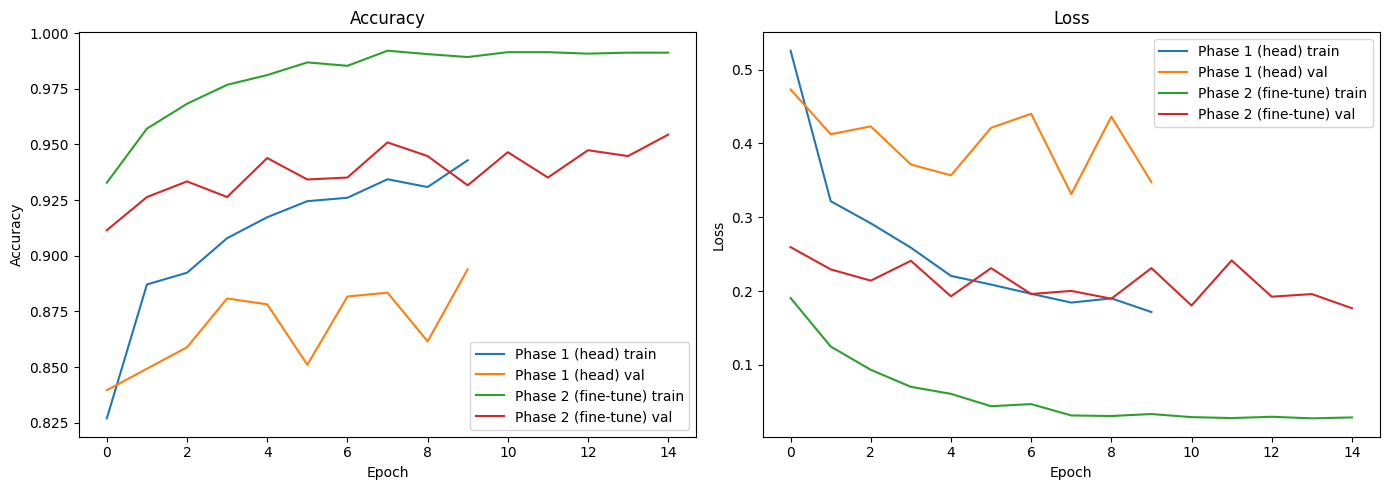

In [25]:

plot_history([history_phase1, history_phase2], ['Phase 1 (head)', 'Phase 2 (fine-tune)'])

# Save Model With preprocess_input

In [41]:
from tensorflow.keras.layers import Lambda, Input
from tensorflow.keras.models import Model


In [42]:
input_layer = Input(shape=(224, 224, 3), name="raw_image")

preprocess_layer = Lambda(preprocess_input, name="preprocessing")(input_layer)

output = model(preprocess_layer)

full_model = Model(inputs=input_layer, outputs=output, name="ResNet50_with_preprocessing")
full_model.save("brain_tumor_resnet50_with_preprocessing.keras")


# import Model

In [3]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf


class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

img_path = 'Testing/glioma/Te-gl_0035.jpg'
model = load_model(
    "brain_tumor_resnet50_with_preprocessing.keras",
    custom_objects={"preprocess_input": preprocess_input}
)

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224,224))
img = tf.keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)   
pred = model.predict(img)
print(class_names[np.argmax(pred)])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
glioma


# Card CAM

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.resnet50 import preprocess_input

model = load_model(
    "brain_tumor_resnet50_with_preprocessing.keras",
    custom_objects={"preprocess_input": preprocess_input}
)

In [2]:
img_path = 'H:\\New folder\\project\\Medical Image Analysis Brain Tumor\\Testing\\glioma\\Te-gl_0011.jpg'

def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))

    img_array = np.expand_dims(img, axis=0)
    img_array = preprocess_input(img_array)

    print(img_array.shape)
    preds = model.predict(img_array)
    print(preds, np.argmax(preds[0]))

    return img_array , preds

img_array, preds = load_and_preprocess_image(img_path)

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[0.63546455 0.00401086 0.3485135  0.01201106]] 0


In [3]:
backbone = model.get_layer('sequential').get_layer('resnet50')
last_conv_layer_name = "conv5_block3_out"


In [4]:
def create_feature_extractor_and_classifier(model,last_conv_layer_name):
    last_conv_layer = backbone.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(backbone.input, last_conv_layer.output)

    classifier_layer_names = [
        "global_average_pooling2d",
        "dense",
        "batch_normalization",
        "dropout",
        "dense_1",
        "batch_normalization_1",
        "dropout_1",
        "output"
    ]

    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input

    for layer_name in classifier_layer_names:
        x = model.get_layer('sequential').get_layer(layer_name)(x)

    classifier_model = Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_output)

        preds = classifier_model(last_conv_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()

    last_conv_output = last_conv_output.numpy()[0]

    for i in range(pooled_grads.shape[-1]):
        last_conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.sum(last_conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

heatmap = create_feature_extractor_and_classifier(model, last_conv_layer_name)



c:\Users\abdoa\anaconda3\envs\ml\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


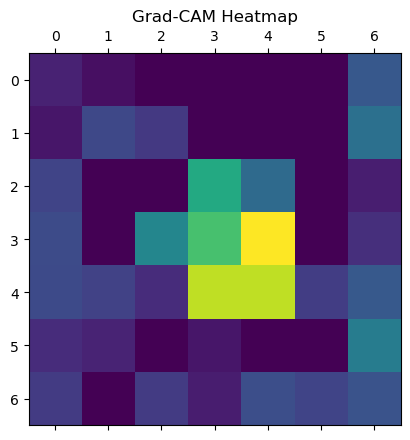

In [5]:
plt.matshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.show()


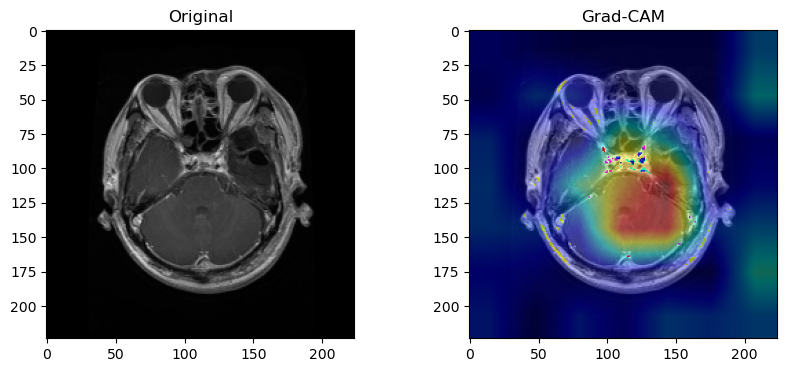

In [6]:
def display_gradcam_on_image(img_path, heatmap):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224,224))
    heatmap_resized = cv2.resize(heatmap, (224,224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = heatmap_color * 0.4 + img
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original")

    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.show()

display_gradcam_on_image(img_path, heatmap)